# Aircraft in Satellite Imagery
## Stage 1: Exploratory Data Analysis


### Data Import

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import collections
import random
import os
import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
from aircraft_proc import *

# set matplotlib parameters
%matplotlib inline
plt.rcParams['axes.grid'] = True
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['grid.color'] = 'k'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

In [2]:
with open('./planesnet/planesnet.json', mode='r') as file:
    planesdict = json.load(file)
df = pd.DataFrame(planesdict)
df.head()

,data,labels,locations,scene_ids
0,"[206, 195, 187, 183, 177, 175, 174, 193, 198, ...",1,"[-118.40497658522878, 33.940618514147936]",20170620_175442_0e30
1,"[215, 209, 200, 196, 192, 197, 205, 168, 155, ...",1,"[-122.392469714, 37.6176425378]",20161212_180859_0e30
2,"[204, 214, 220, 219, 213, 205, 198, 193, 199, ...",1,"[-122.397578597, 37.6209247852]",20170524_181349_0e2f
3,"[179, 174, 179, 178, 173, 170, 168, 168, 168, ...",1,"[-122.214849831, 37.7203378331]",20161110_180707_0e1f
4,"[222, 222, 218, 214, 208, 205, 207, 206, 206, ...",1,"[-117.862173435, 33.6796854072]",20160813_184932_0c64


The purpose of this project is to classify images as "plane" or "not-plane" within a dataset of satellite images collected over California. 

A total of 32000 images are provided, the images are 20x20 pixels in size, each with three bands (RGB), delivered in a JSON formatted file containing data, labels, scene id's, latitude, and longitude.

**The "plane" class includes 8000 images:**

1. The first set of 8000 images are near-centered on the body of a single airplane, with the majority of the plane's wings, tail, and nose visible. 

**The "not-plane" class includes 24000 images:**

2. The second set of 8000 images are a random sampling of different 'land-cover' features - water, vegetation, bare earth, buildings, etc. - that do not include any portion of an airplane. 


3. The third set of 8000 images are 'partial planes' that contain only a portion of an airplane. 


4. The fourth set of 8000 are 'confusers' - chips with bright objects or strong linear features that resemble a plane.

###  Map of Locations of Satellite Images Over California 
*** 

A map is displayed to show the locations of the satellite images taken over California. These include all 'plane', and all 'not-plane'.

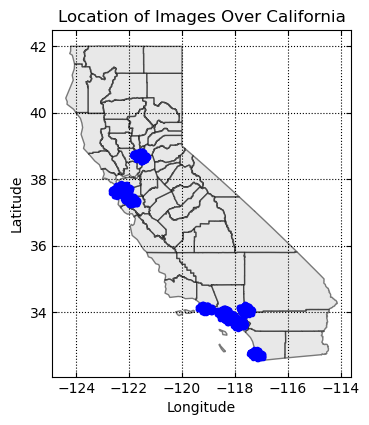

In [3]:
# list of Latitudes and Longitudes, import California shapefile
lons = [lon for lon, lat in planesdict['locations']]
lats = [lat for lon, lat in planesdict['locations']]
cali = gpd.read_file( './maps/CA_counties/CA_counties.shp')

# plot location of images in California
fig, ax = plt.subplots(figsize=(5, 4.5))
ax.plot(lons, lats, linestyle='none', marker='.', color='blue')
cali.plot(ax=ax, color='lightgray', alpha=0.5, edgecolor='k')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Location of Images Over California', size=12)
# plt.savefig(cwd + '/figures/Cali_map.png')
# plt.tight_layout()
plt.show()

### Classification Scheme
***

75% of the 32000 images are classified as 'not-plane', the remaining 25% are classified as 'plane'.

The "plane" class includes 8000 images, and the "not-plane" class includes 24000 images. 

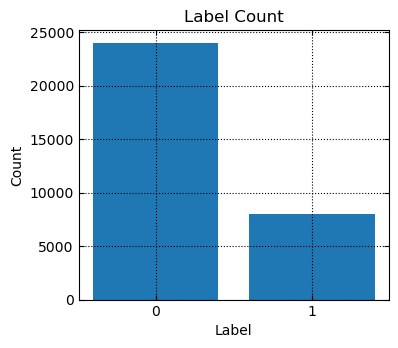

75% Not-Planes (0)
25% Planes (1)


In [4]:

label_count = collections.Counter(planesdict['labels'])
fig, ax = plt.subplots(figsize=(4., 3.5))
ax.bar(label_count.keys(), label_count.values())
ax.set_xticks(ticks=[0,1])
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_title('Label Count', size=12)
plt.show()

print('{}% Not-Planes (0)'.format(int(label_count[0]/32000 *100)))
print('{}% Planes (1)'.format(int(label_count[1]/32000 *100)))

### Sample Satellite Images
***

Twelve satellite images from the dataset are displayed below, three of class 'plane', and nine of class 'not-plane'.

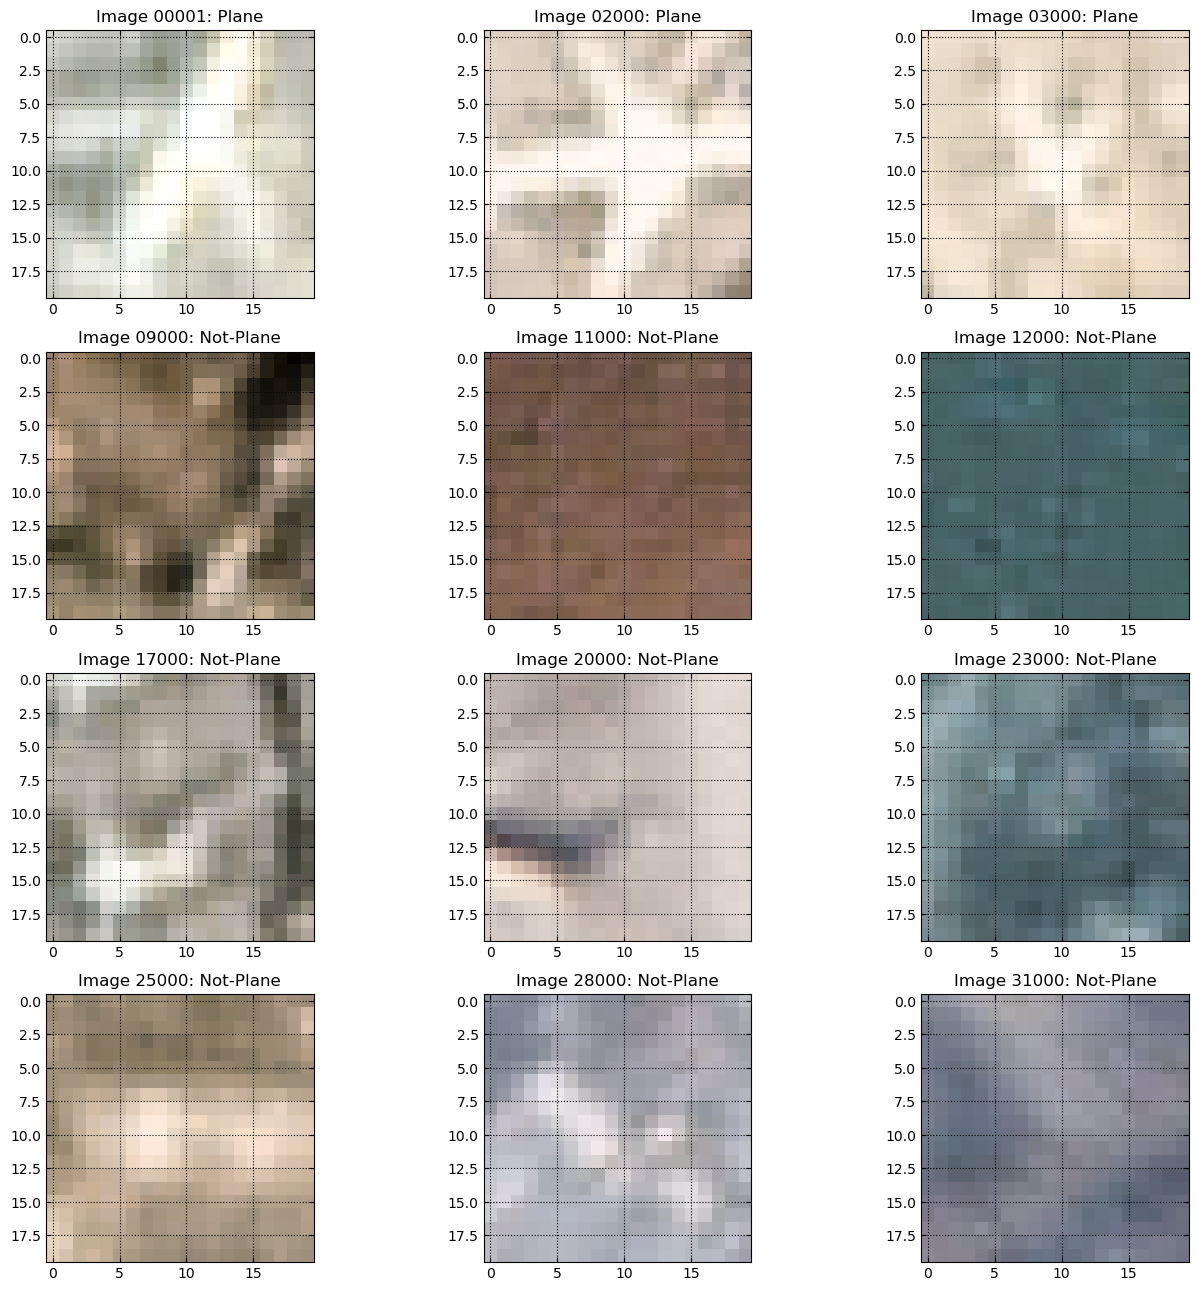

In [5]:
# satellite images of 'plane' and 'not-plane'
plt.figure(figsize=(16, 16))
for index, value in enumerate(images_to_plot):
    plt.subplot(4, 3, index+1)
    img = np.array(planesdict['data'][value]) 
    img = img.reshape((3, 400)).T.reshape((20,20,3))
    
    if planesdict['labels'][value] == 1:
        label = 'Plane'
    else:
        label = 'Not-Plane'
        
    plt.title('Image {:05d}: '.format(value) + label, size=12)
    plt.imshow(img)
# plt.savefig(cwd + '/figures/exmp_imgs.png')
# plt.tight_layout()    
plt.show()

### Root Mean Square (RMS) Display
***

RMS pixel intensity is calculated for each satellite image. RMS can be used to visually summarize pixel intensity within the dataset.

From the display below, it appears that the 'land-cover' images have both the highest, and lowest RMS values within the dataset. It could be interpreted that the 'land-cover' images tend to have stronger reflectivity properties than other images in the dataset. This interpretation can be visually cross-checked by looking at the twelve images displayed above.

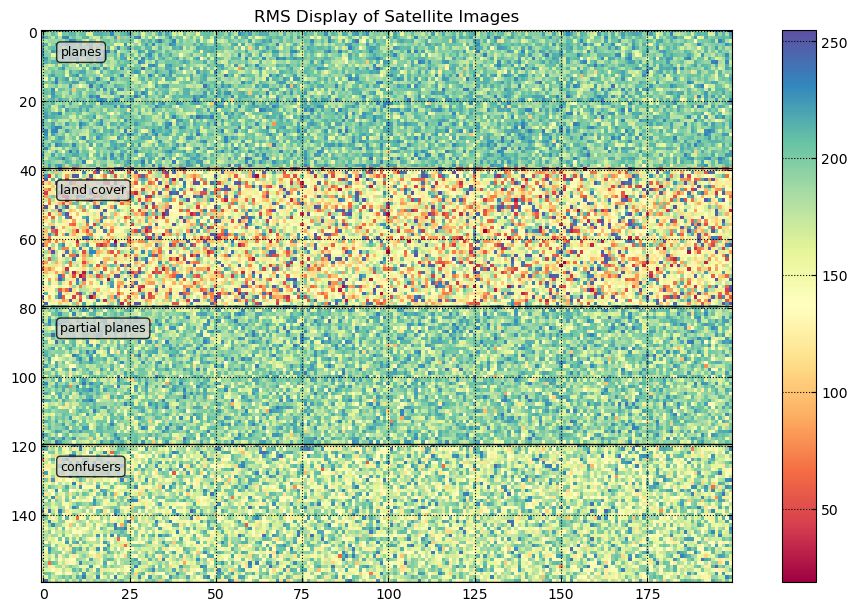

In [6]:
# calculate RMS with all pixels, for each satellite image
RMS_pixels = [np.sqrt(np.mean(np.array(img)**2)) for img in planesdict['data']]
RMS_pixels = np.array(RMS_pixels).reshape((160, 200))

# plot RMS
plt.figure(figsize=(10, 10))
ax = plt.gca() # get the current axes instance on the current figure
img = plt.imshow(RMS_pixels, cmap='Spectral')

line_positions = [40, 80, 120, 160]  # rows 0 to 40 are 'plane', 40 to 80 are 'land-cover', 80 to 120 are 'partial plane', 120 to 160 are 'confusers'
for y in line_positions:
    ax.axhline(y=y-0.5, color='k', linestyle='-', linewidth=1) # subtract 0.5 to center the line

text_positions = [
    {'text': 'planes', 'x': 5, 'y': 7},
    {'text': 'land cover', 'x': 5, 'y': 47},
    {'text': 'partial planes', 'x': 5, 'y': 87},
    {'text': 'confusers', 'x': 5, 'y': 127},
]
# adding text to each section
for text_info in text_positions:
    text = text_info['text']
    x = text_info['x']
    y = text_info['y']
    bbox_props = dict(boxstyle='round', facecolor='lightgrey', edgecolor='k', alpha=0.8)
    ax.text(x, y, text, fontsize=9, bbox=bbox_props, color='black', )

divider = make_axes_locatable(ax) # get axes divider for the axes image is plot in
cax = divider.append_axes('right', size='5%', pad=0.5) #create colorbar axes
ax.set_title('RMS Display of Satellite Images', fontsize=12)
plt.colorbar(img, cax=cax)
# plt.savefig(cwd + '/figures/RMS.png')
# plt.tight_layout()
plt.show()

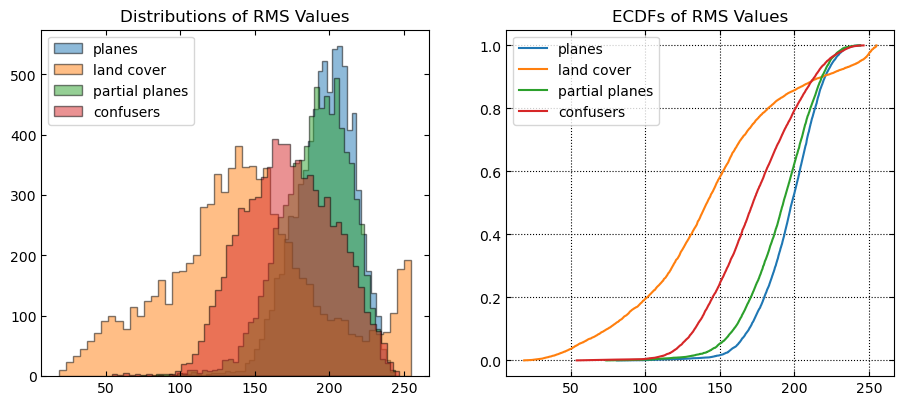

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4.5))
for idx, label in zip([40, 80, 120, 160], ['planes', 'land cover', 'partial planes', 'confusers']):
    sample = RMS_pixels[idx-40:idx, :].ravel()
    ax[0].hist(sample, bins=50, alpha=0.5, histtype='stepfilled', edgecolor='black', linewidth=1, label=label,)
    x = np.sort(sample)
    y = np.arange(1, len(sample) + 1) / len(sample)
    ax[1].plot(x, y, label=label)
    # ax.axvline(np.mean(sample), linewidth=2, label=label + '_mean')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Distributions of RMS Values')
ax[1].set_title('ECDFs of RMS Values') # emperical cumulative distribution function
ax[0].grid(False)
plt.show()

### Bootstrap Hypothesis Test for Statistical Significance
#### Difference in means between RMS groups
***
A hypothesis test is performed to determine whether there is a statistically significant difference in the mean RMS value between 'plane' and 'not-plane' classes.

The null hypothesis is that there is no significant difference in means.

The alternative hypothesis is that there is a significant difference in means.

$H_0$:  $\mu_1$ - $\mu_2$ $=$ 0

$H_a$:  $\mu_1$ - $\mu_2$ $\neq$ 0 

$\alpha$ $=$ $0.05$

In [8]:
rms_planes = RMS_pixels[0:40, :].ravel()
rms_land_cover = RMS_pixels[40:80, :].ravel()
rms_partial_planes = RMS_pixels[80:120, :].ravel()
rms_confusers = RMS_pixels[120:160, :].ravel()

In [9]:
np.random.seed(0)
# define the two groups and means
group1 = rms_planes
group2 = rms_partial_planes

n = 9999 # set a suitably large number of bootstrap replicates
sample_size = len(rms_planes) # sample size is 8000 for all four groups (i.e., planes, land cover, partial planes, confusers)

mean_group1 = np.mean(group1)
mean_group2 = np.mean(group2)

obs_diff = mean_group1 - mean_group2
mean_groups_combined = np.mean(np.concatenate([group1, group2]))

# shift the groups, assume the null hypothesis i.e., that there is no difference in means
group1_shifted = group1 - mean_group1 + mean_groups_combined
group2_shifted = group2 - mean_group2 + mean_groups_combined

# generate bootstrap replicates
bs_sample_means_group1 = np.mean(np.random.choice(group1_shifted, size=(n, sample_size)), axis=1)
bs_sample_means_group2 = np.mean(np.random.choice(group2_shifted, size=(n, sample_size)), axis=1)

bs_diffs = bs_sample_means_group1 - bs_sample_means_group2
bs_p_value = sum(bs_diffs > obs_diff) / len(bs_diffs)

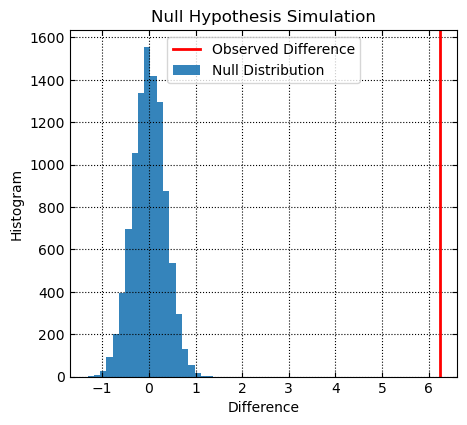

The p-value is 0
The observed difference is 6.2


In [10]:
# plot the null hypothesis simulation results
fig, ax = plt.subplots(figsize=(5, 4.5))
ax.hist(bs_diffs, alpha=0.9, bins=20)
ax.axvline(obs_diff, color='red', linewidth=2)
ax.set_xlabel('Difference')
ax.set_ylabel('Histogram')
ax.legend(labels=('Observed Difference', 'Null Distribution'), fontsize=10)
ax.set_title('Null Hypothesis Simulation', size=12)
plt.show()

print('The p-value is', round(bs_p_value))
print('The observed difference is', round(obs_diff, 1))

### RGB Band Split
***
Red, green, and blue (RGB) bands or channels represent the primary colors of an image. These three bands in are separated and displayed to visually inspect the pixel intensity of the bands within a few select satellite images. Based on visual inspection, it is difficult to determine whether the bands are well balanced, or if there is an overly dominant or weak band when comparing the band intensities of an individual image. However, it appears that there may be some variation in band intensity between the 'plane' and 'not-plane' classes.

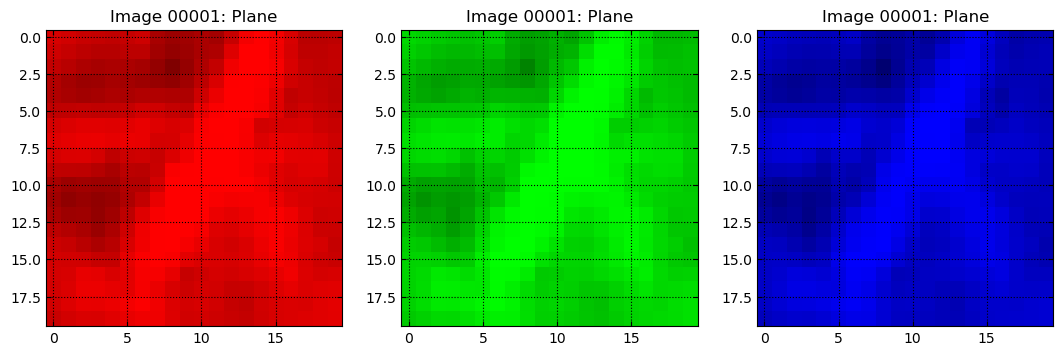

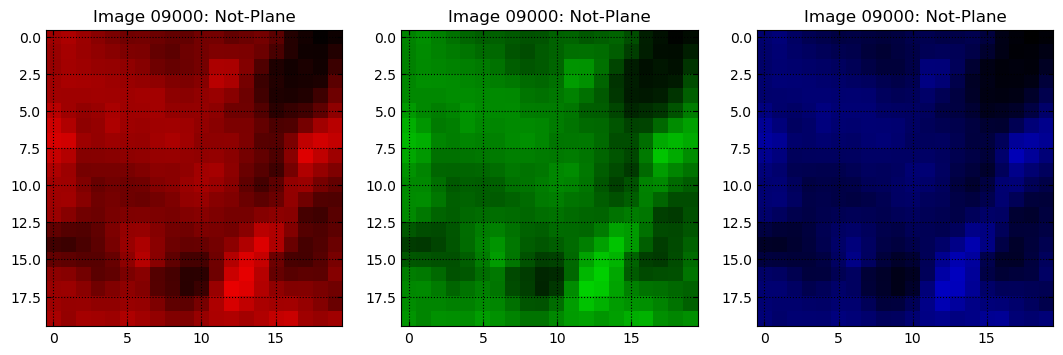

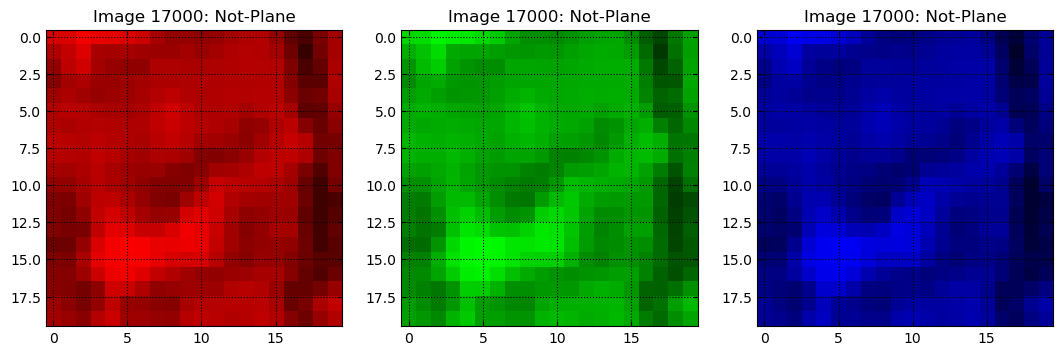

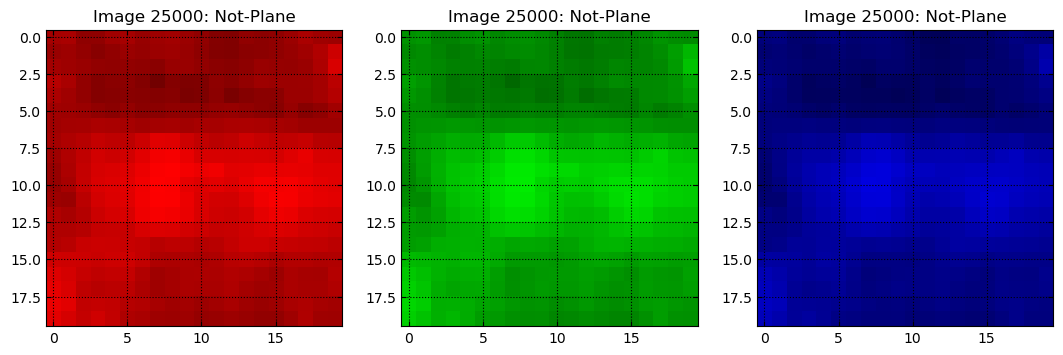

In [11]:
# RGB channels of 'plane' and 'not-plane'
for index in [1, 9000, 17000, 25000]:
    plt.figure(figsize=(13, 6))
    for n in range(1,4):
        plt.subplot(1, 3, n)
        img = np.array(planesdict['data'][index])
        img = img.reshape((3,400)).T.reshape((20,20,3))
        temp = np.zeros(img.shape)
        temp[:, :, n-1] = img[:, :, n-1] / 255
        
        if planesdict['labels'][index] == 1:
            label = 'Plane'
        else:
            label = 'Not-Plane'
        
        plt.title('Image {:05d}: '.format(index) + label, size=12)
        plt.imshow(temp)
    # plt.savefig(cwd + '/figures/rgb_img_{}.png'.format(index))
    # plt.tight_layout()
    plt.show()

### Grayscale Images and RGB Bands
***
The nine images from above are re-displayed in grayscale, along with pixel intensity distributions of the three bands provided in the dataset: red, green, and blue. 

There appears to be variation between the bands of 'plane' and 'not-plane' classes. From visual inspection, the 'plane' class bands tend to show flatter peaks, while the 'not-plane' class shows sharper peaks on each band.

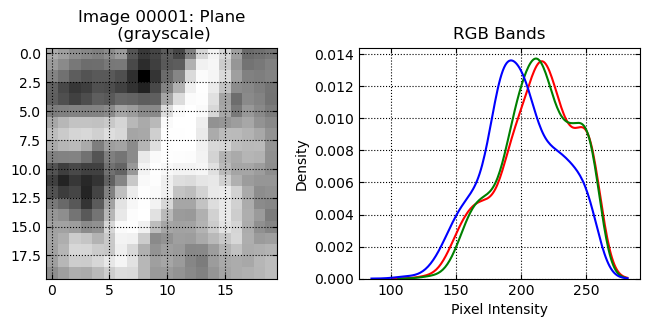

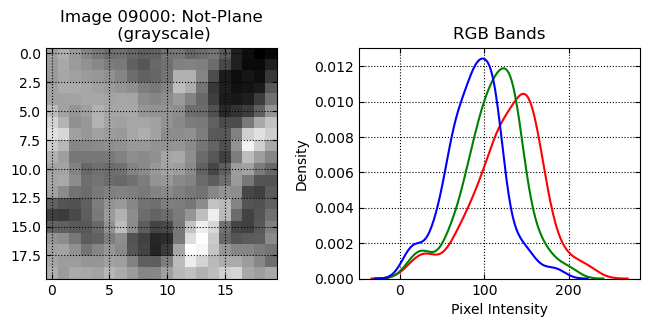

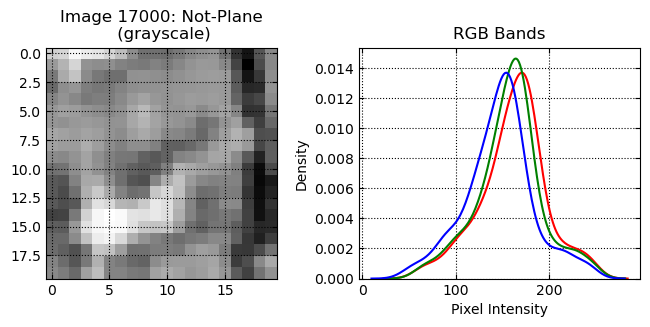

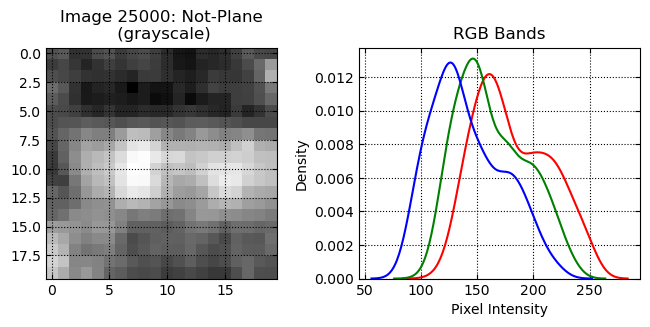

In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

for index in images_to_plot[::3]:
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    img = np.array(planesdict['data'][index]) 
    img = img.reshape((3, 400)).T.reshape((20,20,3))
    img = np.sum(img, axis=2)
    if planesdict['labels'][index] == 1:
        label = 'Plane'
    else:
        label = 'Not-Plane'
    plt.title('Image {:05d}: '.format(index) + label + '\n (grayscale)', size=12)
    plt.imshow(img, cmap='gist_gray')
    
    plt.subplot(1, 2, 2)
    sns.kdeplot(planesdict['data'][index][0:400], color='red')
    sns.kdeplot(planesdict['data'][index][400:800], color='green')
    sns.kdeplot(planesdict['data'][index][800:1200], color='blue')
    
    # plt.grid(color='k', linestyle=':', linewidth=0.5, alpha=0.7)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Density')
    plt.title('RGB Bands', size=12)
    # plt.savefig(cwd + '/figures/grayscale{}.png'.format(index))
    # plt.tight_layout()
    plt.show()


### RGB Bands of Plane and Not-Plane Classes
***
The aggregate distributions of red, green, and blue bands of 'plane' and 'not-plane' classes are plotted below. 

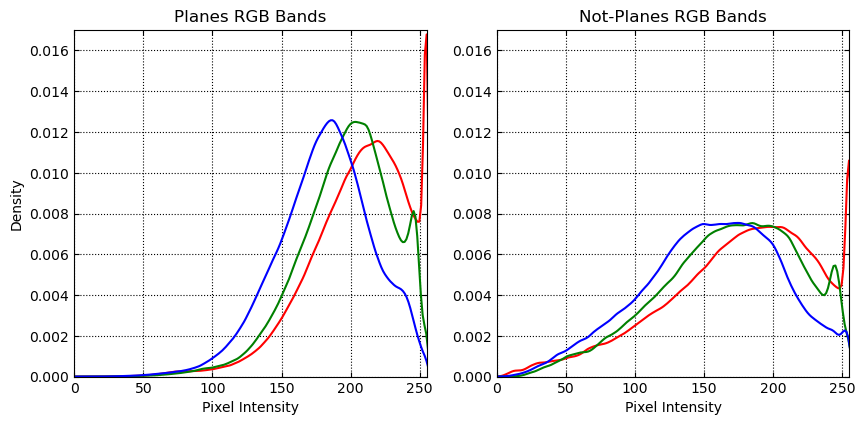

In [13]:
# pixel intensities for all 'plane' images (label 1)
reds_planes = []
greens_planes = []
blues_planes = []

for img in planesdict['data'][:8000]: # first 8000 images are planes (1)
    reds_planes.append(img[0:400])
    greens_planes.append(img[400:800])
    blues_planes.append(img[800:1200])
    
reds_planes = [item for sublist in reds_planes for item in sublist]
greens_planes = [item for sublist in greens_planes for item in sublist]
blues_planes = [item for sublist in blues_planes for item in sublist]

# pixel intensities for all 'not-plane' images (label 0)
reds_notplanes = []
greens_notplanes = []
blues_notplanes = []

for img in planesdict['data'][8000:]: # last 24000 images are 'not-plane' (0)
    reds_notplanes.append(img[0:400])
    greens_notplanes.append(img[400:800])
    blues_notplanes.append(img[800:1200])
    
reds_notplanes = [item for sublist in reds_notplanes for item in sublist]
greens_notplanes = [item for sublist in greens_notplanes for item in sublist]
blues_notplanes = [item for sublist in blues_notplanes for item in sublist]

# kde plots
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
sns.kdeplot(reds_planes, color='red', ax=ax[0])
sns.kdeplot(greens_planes, color='green', ax=ax[0])
sns.kdeplot(blues_planes, color='blue', ax=ax[0])
sns.kdeplot(reds_notplanes, color='red', ax=ax[1])
sns.kdeplot(greens_notplanes, color='green', ax=ax[1])
sns.kdeplot(blues_notplanes, color='blue', ax=ax[1])
ax[0].set_xlabel('Pixel Intensity')
ax[0].set_ylabel('Density')
ax[0].set_xlim(0, 255)
ax[0].set_ylim(0, 0.017)
# ax[0].grid(color='k', linestyle=':', linewidth=0.5, alpha=0.7)
ax[0].set_title('Planes RGB Bands', size=12)

ax[1].set_xlabel('Pixel Intensity')
ax[1].set_ylabel('')
ax[1].set_xlim(0, 255)
ax[1].set_ylim(0, 0.017)
ax[1].set_title('Not-Planes RGB Bands', size=12)
# ax[1].grid(color='k', linestyle=':', linewidth=0.5, alpha=0.7)
# plt.savefig(cwd + '/figures/rgb_dists.png')
# plt.tight_layout()
plt.show()

### Bootstrap Hypothesis Test for Statistical Significance
#### Difference in means between RGB bands of groups
***
A hypothesis test is performed to determine whether there is a statistically significant difference in the mean pixel intensity between 'plane' and 'not-plane' classes.

The null hypothesis is that there is no significant difference in the mean pixel intensity between 'plane' and 'not-plane' classes. 

The alternative hypothesis is that there is a significant difference between the means.

$H_0$:  $\mu_1$ - $\mu_2$ $=$ 0

$H_a$:  $\mu_1$ - $\mu_2$ $\neq$ 0 

$\alpha$ $=$ $0.05$

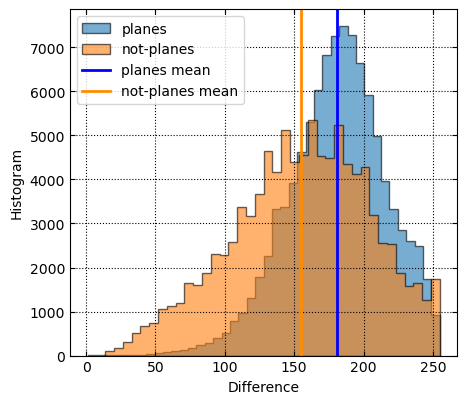

In [14]:
np.random.seed(0)
random_sample_group1 = np.random.choice(blues_planes, size=100000)
random_sample_group2 = np.random.choice(blues_notplanes, size=100000)

fig, ax = plt.subplots(figsize=(5, 4.5))
ax.hist(random_sample_group1, bins=40, alpha=0.6, histtype='stepfilled', edgecolor='k', color='tab:blue', label='planes')
ax.hist(random_sample_group2, bins=40, alpha=0.6, histtype='stepfilled', edgecolor='k', color='tab:orange', label='not-planes')
ax.axvline(np.mean(random_sample_group1), color='blue', linewidth=2, label='planes mean')
ax.axvline(np.mean(random_sample_group2), color='darkorange', linewidth=2, label='not-planes mean')

ax.set_xlabel('Difference')
ax.set_ylabel('Histogram')

plt.legend()
plt.show()

In [15]:
# define the groups and means
group1 = blues_planes
group2 = blues_notplanes

n = 9999 
sample_size = 99999

mean_group1 = np.mean(group1)
mean_group2 = np.mean(group2)

obs_diff = mean_group1 - mean_group2
mean_groups_combined = np.mean(np.concatenate([group1, group2]))

# shift the groups, assume the null hypothesis i.e., that there is no difference in means
group1_shifted = group1 - mean_group1 + mean_groups_combined
group2_shifted = group2 - mean_group2 + mean_groups_combined

# generate bootstrap replicates
bs_sample_means_group1 = np.mean(np.random.choice(group1_shifted, size=(n, sample_size)), axis=1)
bs_sample_means_group2 = np.mean(np.random.choice(group2_shifted, size=(n, sample_size)), axis=1)

bs_diffs = bs_sample_means_group1 - bs_sample_means_group2
bs_p_value = sum(bs_diffs > obs_diff) / len(bs_diffs)

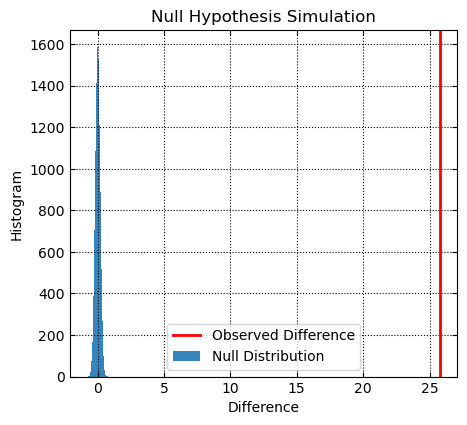

The p-value is 0
The observed difference is 25.8


In [16]:
# plot the null hypothesis simulation results
fig, ax = plt.subplots(figsize=(5, 4.5))
ax.hist(bs_diffs, alpha=0.9, bins=20)
ax.axvline(obs_diff, color='red', linewidth=2)
ax.set_xlabel('Difference')
ax.set_ylabel('Histogram')
ax.legend(labels=('Observed Difference', 'Null Distribution'), fontsize=10)
ax.set_title('Null Hypothesis Simulation', size=12)
plt.show()

print('The p-value is', round(bs_p_value))
print('The observed difference is', round(obs_diff, 1))